# TP 1 -  AI for OSINT

De nombreuse informations sur un profil sont aujourd'hui disponibles sur internet grâce aux réseaux sociaux. Ces informations peuvent permettre à un potentiel attaquant d'identifier les cibles les plus pertinentes pour lancer une attaque de spear phishing ou faire du social engineering.

Cependant, l'investigation en ligne (OSINT) est coûteuse en temps humain : les cibles sont de plus en plus nombreuses et la quantité d'information disponible explose. Les méthodes d'IA permettent aux attaquants d'automatiser cette première phase de reconnaissance

# *Clustering Twitter Users*

Pour trouver les cibles les plus susceptible de mordre à l'hameçon, la première étape de la pipeline consiste en un algorithme de clustering qui place un utilisateur donné dans la catégorie "High Value Target" ou non. 

Dans ce TP, nous allons nous intéresser aux jeux olympiques de Tokyo 2020.

## Outline

Ce TP est divisé en 5 tâches,  : 
- Récupérer et comprendre les données utilisées
- Définir les caractéristiques à extraire (feature engineering)
- Sélection et paramétrisation d'un modèle
- Évaluation des performances
- Itération des modèles

## Mise en place de l'environnement

Avant de commencer, commencez par créer et activer un environnement virtuel Python qui servira pour ce TP :
```
$ python3 -m venv .venv
$ source .venv/bin/activate
```

Installez ensuite les dépendances nécessaire :
````
$ pip install -r requirements.py
````


Définissez l'environnement virtuel comme kernel jupiter, puis exécutez la cellul suivante pour importer les librairies qui nous seront utiles.

In [1]:
import os
import csv

## Récupération et compréhension des données

Nous allons travailler avec des données plubliquement accessibles sur Twitter. 

Nous verrons dans un premier temps comment mettre en place un client pour requêter l'API de twitter et récupérer nous-même les données. 

Ensuite, nous utiliserons un jeu de données déjà construit, sur les JO de Tokyo. Elles ont été collectées à l'aide de la librairie tweepy pour accéder à l'API de Twitter, en utilisant hashtag pertinent pour le sujet (#Tokyo2020)

### Mise en place du client

Vous pouvez créer un compte Twitter, et remplir ci-dessous vos credentials. 

In [4]:
from twikit.client import Client

client = Client(language='en-US')
client.login(auth_info_1='username',
             password='pwd')
client.save_cookies('cookies.json')


In [ ]:
client.load_cookies(path='cookies.json')
user = client.get_user_by_screen_name()
print(user.name)


### Récupération des données

1. Définir une requête pertinente pour les données qui nous intéressent, et utiliser les mots-clés `since:YYYY-MM-DD` et `until:YYYY-MM-DD` pour cadrer la date.

In [2]:
query = 'Tokyo2020 since:2020-07-23 until:2020-08-08'

2. Écrire une fonction `get_tweets` qui permette de récupérer les tweets correspondant à la requête définie ci-dessus, et de sauvegarder les informations qui nous intéressent dans un fichier csv local. On limitera ici le nombre de tweets téléchargés à 500.
    
    *Indice : utilisez la fonction `client.search_tweets()`de `twikit` pour requêter l'API. Explorez dans un premier temps les métadonnées qui peuvent être disponibles pour un tweet*

    Attention ! L'API a une rate-limit de 500 tweets toutes les 15 minutes

In [ ]:
tweet = client.search_tweet(query = query, product='Top', count=10)

In [ ]:
filepath=os.path.join('data', 'twikit_tokyo_2020_tweets.csv')

columns = ['id', 'user_name', 'user_location', 'user_description', 'user_created', 
           'user_followers', 'user_verified',
           'date','text','hashtags','retweets','favorites','is_retweet'
]

def get_tweets(client, query, filepath=filepath, max_results=50):
    tweets = [] 
    results = client.search_tweet(query = query, product='Top', count=max_results)
    tweets+=results
    while True:
        tweets += results.next()
        print(len(tweets))
        if len(tweets)>= max_results:
            break
    print(len(tweets))
    with open(filepath, 'w', newline='') as f:
        writer = csv.writer(f, delimiter = ',')
        writer.writerow(columns)
        for tweet in tweets:
            writer.writerow([tweet.id, tweet.user.name, tweet.user.location, tweet.user.description,
                            tweet.user.created_at, tweet.user.followers_count,
                            tweet.user.verified, tweet.created_at, tweet.text, tweet.hashtags, 
                            tweet.retweet_count, tweet.favorite_count, tweet.retweeted_tweet])

    return 

3. Utiliser `get_tweets()`pour récupérer les tweets qui nous intéressent, et vérifier brièvement que les résultats correspondent à nos attentes.

In [ ]:
client.load_cookies(path='cookies.json')
tweets = get_tweets(client, query)

In [ ]:
len(tweets)

In [ ]:
tweets[0].text

Pour aller plus vite, dans la suite du TD, nous utiliserons tous le même jeu de données sur les JO de Tokyo en 2020.
Le fichier CSV contenant les colonnes qui nous intéresse est disponible dans le dossier `data`.

### Visualisation des données

Maintenant que nous avons collecté les données, il est important de les connaître et de les comprendre : sont-elles pertinentes ? Y a-t-il du bruit ? Peut-on le filtrer ? Toutes ces questions nécessitent un inspection minutieuse des résultats obtenus. 

3. La bibliothèque la plus couramment utilisée pour le traitement de données en Data Science est `pandas`(ref to pandas). Utiliser cet outil pour créer un dataframe contenant les colonnes `'date'`, `'text'` et `'user_name'`.  
    
    *Indice : la fonction `to_datetime()` est utile pour manipuler plus facilement les données temporelles*

In [5]:
import pandas as pd

In [6]:
def tweets_to_df():
    """Helper func to extract specific tweet features into a dataframe."""
    tweet_df = pd.read_csv('data/tokyo_2020_tweets.csv', on_bad_lines='warn')
    
    # creating a datetimeindex will allow us to do more timeseries manipulations
    tweet_df['ts'] = pd.to_datetime(tweet_df['date'],errors='coerce') # skip bad date formatting
    return tweet_df

In [7]:
tweet_df = tweets_to_df()

/var/folders/p0/9k6hg6k13cscchw6zjjs14r80000gn/T/ipykernel_3425/4052242094.py:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  tweet_df = pd.read_csv('data/tokyo_2020_tweets.csv', on_bad_lines='warn')


In [8]:
tweet_df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,ts
0,1418888645105356803,Abhishek Srivastav,"Udupi, India",Trying to be mediocre in many things,2021-02-01 06:33:51,45.0,39.0,293.0,False,2021-07-24 10:59:49,Let the party begin\n#Tokyo2020,['Tokyo2020'],Twitter for Android,0.0,0.0,False,2021-07-24 10:59:49
1,1418888377680678918,Saikhom Mirabai Channu🇮🇳,"Manipur, India",Indian weightlifter 48 kg category. Champion🏆,2018-04-07 10:10:22,5235.0,5.0,2969.0,False,2021-07-24 10:58:45,Congratulations #Tokyo2020 https://t.co/8OFKMs...,['Tokyo2020'],Twitter for Android,0.0,0.0,False,2021-07-24 10:58:45
2,1418888260886073345,Big Breaking,Global,All breaking news related to Financial Market....,2021-05-29 08:51:25,3646.0,3.0,5.0,False,2021-07-24 10:58:17,Big Breaking Now \n\nTokyo Olympic Update \n\n...,NaN,Twitter for Android,0.0,1.0,False,2021-07-24 10:58:17
3,1418888172864299008,International Hockey Federation,Lausanne,Official International Hockey Federation Twitt...,2010-10-20 10:45:59,103975.0,2724.0,36554.0,True,2021-07-24 10:57:56,Q4: 🇬🇧3-1🇿🇦\n\nGreat Britain finally find a wa...,NaN,Twitter Web App,1.0,0.0,False,2021-07-24 10:57:56
4,1418886894478270464,Cameron Hart,Australia,Football & Tennis Coach,2020-10-31 08:46:17,6.0,37.0,31.0,False,2021-07-24 10:52:51,All I can think of every time I watch the ring...,"['Tokyo2020', 'ArtisticGymnastics', '7Olympics...",Twitter for iPhone,0.0,0.0,False,2021-07-24 10:52:51


4. Utiliser les fonctionnalités des dataframes pandas pour visualiser le nombre de tweets par jour de notre ensemble de données

In [10]:
date_df = tweet_df[['ts', 'text']]

<Axes: xlabel='ts'>

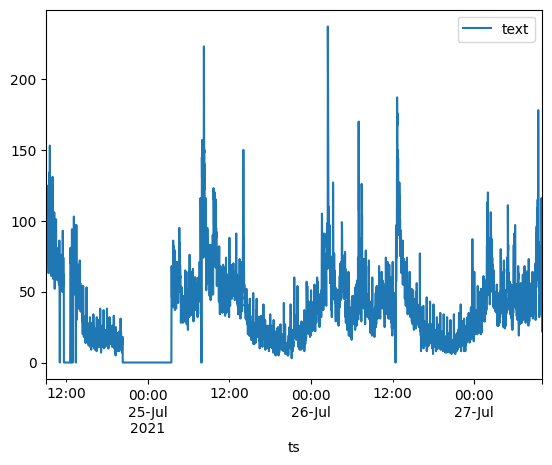

In [11]:
date_df.set_index('ts').resample('1min').count().plot()

5. Et le nombre de tweets par utilisateur ?

In [18]:
user_df = tweet_df[['id', 'user_name']]

In [19]:
user_df.groupby("user_name").count().sort_values(by='id', ascending=False)

,id
user_name,
aLpha sibuea,5395
canadianbestseller.com,755
7Olympics,629
International Hockey Federation,557
Karthik K,540
...,...
Marieke Peuscher,1
BS96,1
Mariel Lacap,1


Avec cet échantillon, faisons un peu de traitement de texte brut pour examiner le contenu des tweets. Une première façon simple - et souvent instructive - d'inspecter le contenu des données textuelles consiste à examiner les n-grammes les plus courants. En modélisation linguistique, un "n-gramme" est une collection contiguë de quelque n éléments - il s'agit souvent de mots séparés par des espaces. Par exemple, les 3-grammes de la phrase "Le chien a mangé mes devoirs" seraient "le chien a", "chien a mangé", "a mangé mes", "mangé mes devoirs".

Nous allons donc afficher les 3-grammes les plus fréquents, afin de se faire une idée des données textuelles dont nous disposons. Si nous voyons un contenu qui ne nous semble pas pertinent, nous pouvons revenir en arrière et modifier notre requête.


6. Calculez les n-grammes les plus courants 

    *Indice : la bibliothèque nltk peut être utile pour tokenizer (séparer en mots) le texte*

In [21]:
from nltk.tokenize.casual import TweetTokenizer
from nltk.util import everygrams
from collections import Counter
import string

In [22]:
def get_all_tokens(tweet_df):
    """
    Helper function to generate a list of text tokens from concatenating
    all of the text contained in Tweets 
    """
    # concat entire corpus
    all_text = ' '.join((txt for txt in tweet_df['text'] if type(txt) == str))
    # tokenize
    tokens = (TweetTokenizer(preserve_case=False,
                            reduce_len=True,
                            strip_handles=False)
              .tokenize(all_text))
    # remove symbol-only tokens for now
    tokens = [tok for tok in tokens if not tok in string.punctuation]
    return tokens

In [23]:
tokens = get_all_tokens(tweet_df)

In [24]:
# calculate a range of ngrams using some handy functions
top_grams = Counter(everygrams(tokens, min_len=4, max_len=6))

top_grams.most_common(25)

[(('the', 'women', '’', 's'), 831),
 (('the', 'men', '’', 's'), 606),
 (('let', '’', 's', 'go'), 468),
 (('in', 'the', 'women', '’'), 434),
 (('in', "women's", '49kg', 'weightlifting'), 433),
 (('in', 'the', 'women', '’', 's'), 427),
 (('so', 'proud', 'of', 'you'), 409),
 (('first', 'medal', 'for', 'india'), 354),
 (('we', 'are', 'proud', 'of'), 345),
 (('are', 'proud', 'of', 'you'), 340),
 (('❤', '️', '❤', '️'), 331),
 (('🥈', 'in', "women's", '49kg'), 329),
 (('🥈', 'in', "women's", '49kg', 'weightlifting'), 315),
 (('hearty', 'congratulations', '@mirabai_chanu', 'for'), 310),
 (('for', 'lifting', '🥈', 'in'), 310),
 (('tom', 'daley', 'and', 'matty'), 310),
 (('congratulations', '@mirabai_chanu', 'for', 'lifting'), 309),
 (('@mirabai_chanu', 'for', 'lifting', '🥈'), 309),
 (('@mirabai_chanu', 'for', 'lifting', '🥈', 'in'), 309),
 (('for', 'lifting', '🥈', 'in', "women's"), 309),
 (('lifting', '🥈', 'in', "women's"), 309),
 (('hearty', 'congratulations', '@mirabai_chanu', 'for', 'lifting'), 

7. Quelles informations peut-on retrouver sur les JO de Tokyo en explorant les données ? 

## Feature Engineering

Le but, ici, est de passer de données semi-structurées (csv) à la matrice de données bidimensionnelle d'observations et de caractéristiques attendue par de nombreuses bibliothèques de ML.

L''objectif de ce TD est de rassembler utilisateurs de Twitter en groupes de similarité. De nombreuses informations peuvent être disponibles via l'API de Twitter, pour plus de simplicité nous nous concentrerons sur la description des utilisateurs. 

### Preprocessing

1. Les liens URL ne sont pas porteurs de beaucoup d'informations (raccourcis par twitter). Commençons par enlever les URL du texte et les remplacer par un pattern unique, `"lien_url"`

In [25]:
import re

In [30]:
def replace_urls(string):
    """Replace URLs in strings
    """
    replacement = 'line_url' 
    pattern = re.compile('(https?://)?(\w*[.]\w+)+([/?=&]+\w+)*')
    try:
        res = re.sub(pattern, replacement, string)
    except:
        res = 'na'
    return res

In [28]:
date_df['text'].apply(replace_urls)

0                           Let the party begin\n#Tokyo2020
1                       Congratulations #Tokyo2020 line_url
2         Big Breaking Now \n\nTokyo Olympic Update \n\n...
3         Q4: 🇬🇧3-1🇿🇦\n\nGreat Britain finally find a wa...
4         All I can think of every time I watch the ring...
                                ...                        
297006    It's a close contest in our first Olympic game...
297007    10 athletes from the IOC @RefugeesOlympic star...
297008    SNACK TIME! \n\nHow could I say no to “two sof...
297009    .\n.\n.\n🏄‍♂️ 𝐊𝐚𝐧𝐨𝐚 𝐈𝐠𝐚𝐫𝐚𝐬𝐡𝐢 🇯🇵\n.\n.\n🥈𝐂𝐨𝐧𝐠𝐫𝐚...
297010    #Breaking - It brings Tokyo’s total to more th...
Name: text, Length: 297011, dtype: object

Une étape importante du traitement de texte consiste à diviser la string en tokens (ou mots). Il existe de nombreuses façons de découper une chaîne de texte en tokens, mais dans le cadre de cette discussion, nous nous intéresserons principalement à l'anglais. Dans ce cas, le découpage du texte via les espaces reste la manière la plus simple de procéder. 

Nous pouvons également choisir de créer notre propre tokenizer explicite si les données (et la tâche) l'exigent. Une méthode particulière qui fonctionne avec les données Twitter est le TweetTokenizer de NLTK. Il préserve les symboles @ et # au début des mots, et peut également "réduire" les caractères répétés - c'est-à-dire que lolll, lollllll, et lollllllllllll se réduiront tous à la même représentation "lolll" (trois "l"). 

2. Créer une fonction `tokenizer()` qui sépare du texte en tokens.

In [31]:
def tokenizer(string):
    """
    Convert `in_string` of text to a list of tokens using NLTK's TweetTokenizer
    """
    # reasonable, but adjustable tokenizer settings
    tokenizer = TweetTokenizer(preserve_case=False,
                               reduce_len=True,
                               strip_handles=False)
    tokens = tokenizer.tokenize(string)
    return tokens

3. Enlever les "stop-words" (mots les plus courants, qui ne sont pas vraiment porteurs d'information - 'the', etc.)

    *Indice : utiliser des listes de stop-words déjà faites, comme celle de `python-stop-words`. Avez-vous pense à tous les langages pertinents ?*

In [32]:
from stop_words import get_stop_words

In [33]:
my_stopwords = get_stop_words('en')

### Vectorisation

La plupart des algorithmes de ML prêts à l'emploi, par exemple ceux de sklearn, attendent une entrée sous forme de matrice de données bidimensionnelle de valeurs numériques : observations (lignes) x caractéristiques (colonnes). Pour créer une représentation numérique de données textuelles, nous devons vectoriser les caractéristiques du texte (tokens).

1. Qu'est-ce que le TF-IDF d'un mot dans un corpus de texte ? 

2. Créer un TF-IDF grâce à sklearn, en tirant parti des arguments `preprocessor`, `stop-words`, `tokenizer` et `max-features`

3. Commentez le résultat : pourquoi la matrice est si sparse (clairsemée) ? 

4. Quelles autres features peut-on ajouter à nos données ? 

## Sélection d'un modèle et de ses hyperparamètres

De nombeaux modèles de clustering sont disponibles via la bibliothèque `scikit-learn`([https://scikit-learn.org/stable/modules/clustering.html])

### K-Means

KMeans est un choix courant car il est très rapide pour des quantités modérées de données. Comme la plupart des algorithmes de ML, KMeans a des hyperparamètres qui doivent être choisis de manière appropriée. Dans le cas présent, ce paramètre est k, le nombre de cluster dans nos données.

En non supervisé, il n'est pas facile de calculer (et d'optimiser) un score de précision. Nous devons donc utiliser d'autres techniques pour comparer les modèles entre eux afin de sélectionner k. Comme nous ne connaissons pas ce nombre a priori, une technique consiste à comparer la valeur d'une certaine métrique de qualité parmi une gamme de k potentiels. Il existe un certain nombre de mesures de qualité connues, dont nous n'utiliserons que deux : le silhouette score et l'inertie.

1. Que représente le silhouette score ? Et l'inertie ?

2. En utilisant `scikit-learn`, calculer le silhouette-score ainsi que l'inertie pour plusieurs valeurs de k différentes : [2, 50, 200, 500] (cette étape peut prendre quelques minutes)

3. En utilisant `matplotlib.pyplot`, afficher l'évolution du silhouette-score et de l'inertie en fonction de la valeur de k

4. Analyser les résultats ci-dessus : quelle serait la meilleure valeur de k ? Comment pourrait-on affiner cette recherche ?

5. Entraîner le modèle, avec les bonnes valeurs de k, sur l'ensemble du jeu de données

## Résultats

1. Combien y a-t-il d'utilisateurs dans chaque cluster ? Que peut-on en déduire ?

Rappelons que les utilisateurs sont représentés dans un espace de paramètres comprenant les mots utilisés dans leur biographie. Dans l'algorithme KMeans, la représentation résultante de ces cluster est constituée des coordonnées du centroïde de chaque cluster dans cet espace de tokens. Ainsi, une autre façon d'examiner nos résultats est de poser la question suivante : pour chaque centroïde de cluster, quels sont les tokens qui ont la plus grande projection sur ce centroïde ? En d'autres termes, quels sont les tokens les plus fortement associés à chaque groupe ?

2. Afficher les n features les plus importantes pour chaque cluster

3. Pour un cluster donné, afficher quelques biographies et analyser les résultats. 

4. (optionnel) : utiliser `MulticoreTSNE`pour résuire la dimension de la représentation des utilisateurs, et représenter en deux dimensions les cluster avec les fonction suivante : 

In [ ]:
def get_plottable_df(users, bios, two_d_coords, labels):
    """
    Combine the necessary pieces of data to create a data structure that plays
    nicely with the our 2d tsne chart.

    Note: assumes that all argument data series
    are in the same order e.g. the first user, bio, coords, and label
    all correspond to the same user.
    """
    # set up color palette
    num_labels = len(set(labels))
    colors = sns.color_palette('hls', num_labels).as_hex()
    color_lookup = {v:k for k,v in zip(colors, set(labels))}
    # combine data into a single df
    df = pd.DataFrame({'uid': users,
                       'text': bios,
                       'label': labels,
                       'x_val': two_d_coords[:,0],
                       'y_val': two_d_coords[:,1],
                      })
    # convert labels to colors
    df['color'] = list(map(lambda x: color_lookup[x], labels))
    return df

def plot_tsne(df, title='t-SNE plot'):
    # add our DataFrame as a ColumnDataSource for Bokeh
    plot_data = ColumnDataSource(df)
    # configure the chart
    tsne_plot = figure(title=title, plot_width=800, plot_height=700, tools=('pan, box_zoom, reset'))
    # add a hover tool to display words on roll-over
    tsne_plot.add_tools(
        HoverTool(tooltips = """<div style="width: 400px;">(@label) @text</div>""")
    )
    # draw the words as circles on the plot
    tsne_plot.circle('x_val', 'y_val',
                     source=plot_data,
                     color='color',
                     line_alpha=0.2,
                     fill_alpha=0.1,
                     size=7,
                     hover_line_color='black')
    # configure visual elements of the plot
    tsne_plot.title.text_font_size = '12pt'
    tsne_plot.xaxis.visible = False
    tsne_plot.yaxis.visible = False
    tsne_plot.grid.grid_line_color = None
    tsne_plot.outline_line_color = None
    return tsne_plot

## Itération

1. Le choix d'un modèle dépend beaucoup des hypothèses faites sur la répartition des données initiales. Quel serait le modèle le plus pertinent selon vous ? Vous pouvez vous référer à [la page d'acceuil scikit learn](https://scikit-learn.org/stable/modules/clustering.html). Réitérer le processus ci dessus avec le modèle choisi.

2. Quelles améliorations pourrait-on faire sur le traitement des données ? 